In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

In [3]:
with open('../../genIII_data/JLab/Cosmic/Run0_list.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue

    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;

    split = line.split()
    layer, channel, LG, HG = split[0:4]

    ID=int(layer)*64+int(channel)

    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        din[f"{ID}_time"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))

In [4]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)
    
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2. * sigma ** 2))

# Fit and process one channel for pedestal

def process_pedestal_channel(data, channel_key, ax, Peds, PedStds, PedErrs, PedStdErrs, gain_type="HG"):
    # Select gain-specific parameters
    if gain_type == "HG":
        max_val = 800
        num_bins = 200
    elif gain_type == "LG":
        max_val = 400
        num_bins = 200
    else:
        raise ValueError("gain_type must be 'HG' or 'LG'")

    # Apply mask and histogram
    raw_data = np.array(data[channel_key])
    gain_mask = raw_data < max_val
    filtered_data = raw_data[gain_mask]
    
    counts, bin_edges = np.histogram(filtered_data[filtered_data > 0], bins=num_bins, range=(0, max_val))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    y_errors = np.sqrt(counts)

    # Only use bins with data for fitting
    mask = counts > 0
    x_data = bin_centers[mask]
    y_data = counts[mask]
    fit_errors = y_errors[mask]

    # Fit with Minuit
    initial_params = [max(y_data), np.mean(filtered_data), np.std(filtered_data)]
    least_squares = LeastSquares(x_data, y_data, fit_errors, gauss)
    m = Minuit(least_squares, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()

    # Extract results
    fit_vals = m.values
    fit_errs = m.errors
    A_fit = fit_vals['A']
    mu_fit = fit_vals['mu']
    sigma_fit = fit_vals['sigma']

    # Plot
    ax.errorbar(bin_centers, counts, yerr=y_errors, fmt='o', label=channel_key)
    fit_x = np.linspace(0, max_val, 1500)
    fit_y = gauss(fit_x, A_fit, mu_fit, sigma_fit)
    ax.plot(fit_x, fit_y, color='tab:orange')
    ax.set_xlim(0, max_val)

    # Append results
    Peds.append(mu_fit)
    PedStds.append(sigma_fit)
    PedErrs.append(fit_errs['mu'])
    PedStdErrs.append(fit_errs['sigma'])
    
    
def analyze_pedestal_unit(din, caen_unit, Peds, PedStds, PedErrs, PedStdErrs, gain_type="HG"):
    num_channels = 64
    num_cols = 8
    num_rows = num_channels // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i in range(num_channels):
        channel_number = i + (64 * caen_unit)
        channel_key = f"{channel_number}_{gain_type}"
        process_pedestal_channel(din, channel_key, axes[i], Peds, PedStds, PedErrs, PedStdErrs, gain_type=gain_type)

        if i % num_cols == 0:
            axes[i].set_ylabel("Counts")
        if i >= num_channels - num_cols:
            axes[i].set_xlabel("ADC Value")

    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f"Pedestal Fits (Unit {caen_unit}, {gain_type})", y=1.02, fontsize=16)
    plt.show()

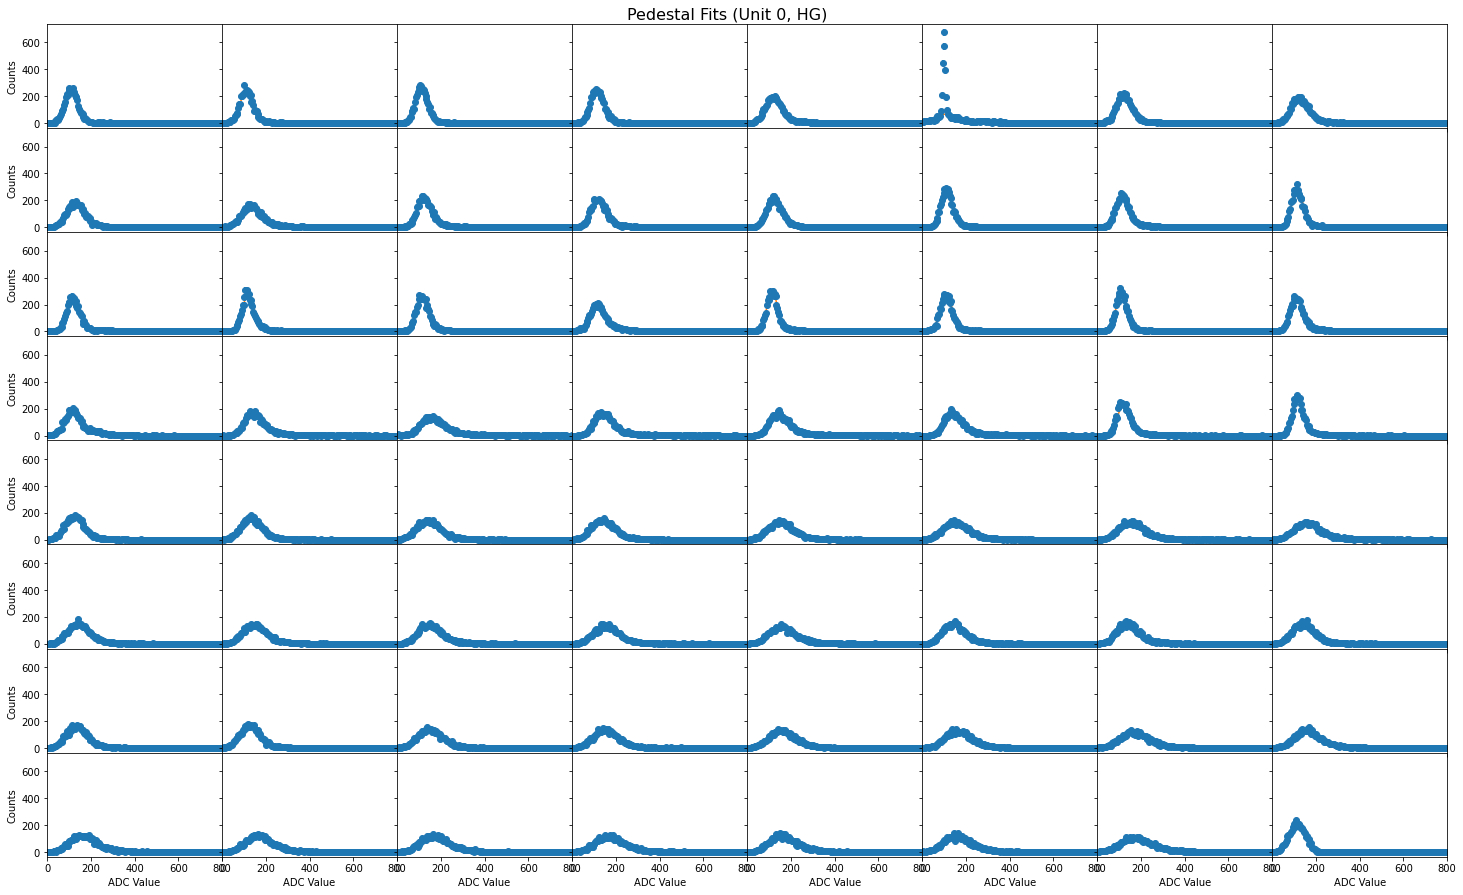

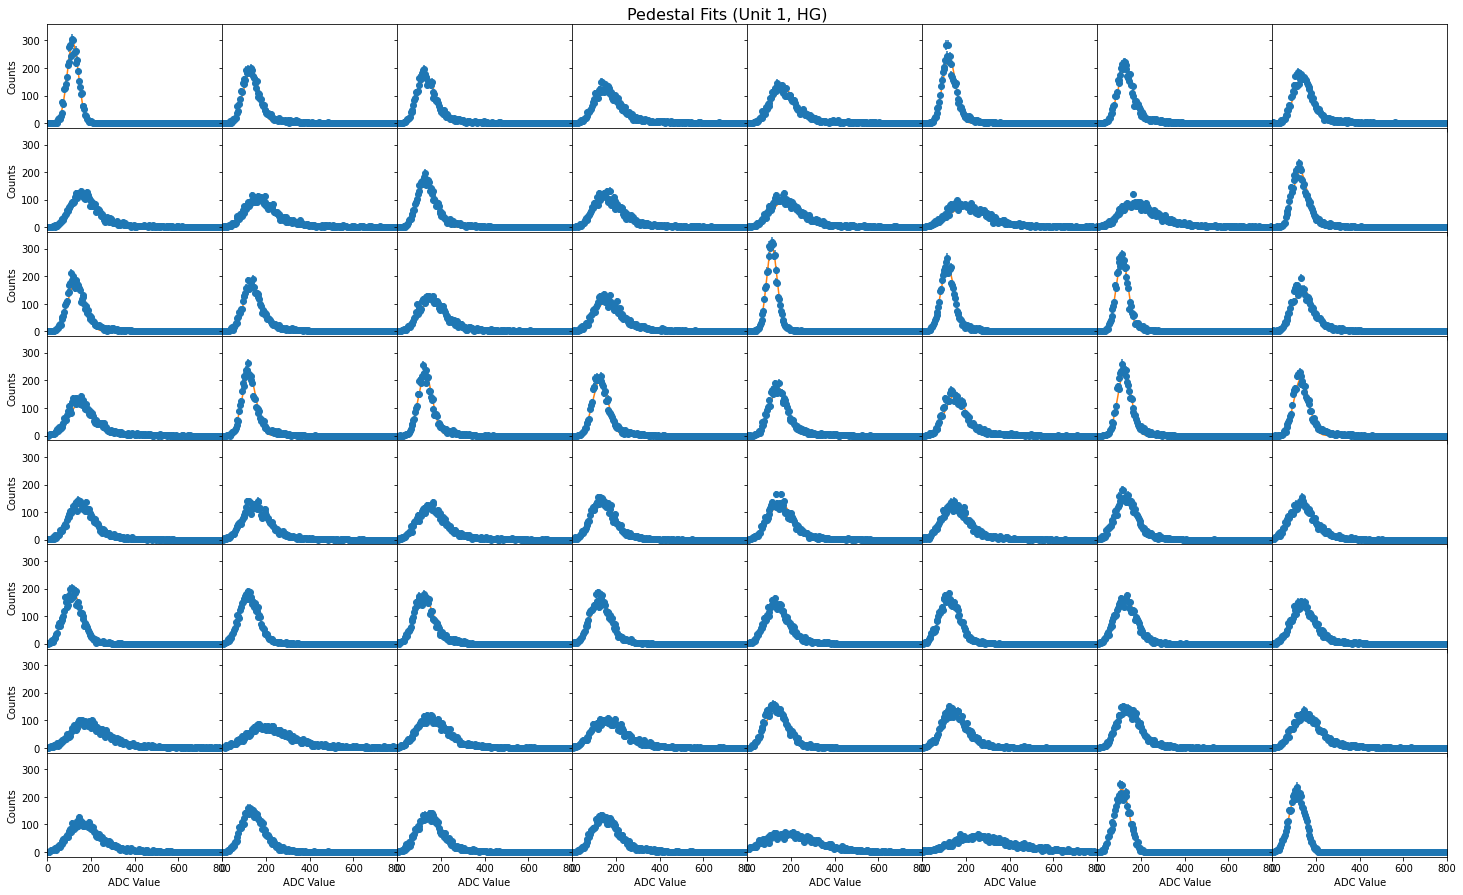

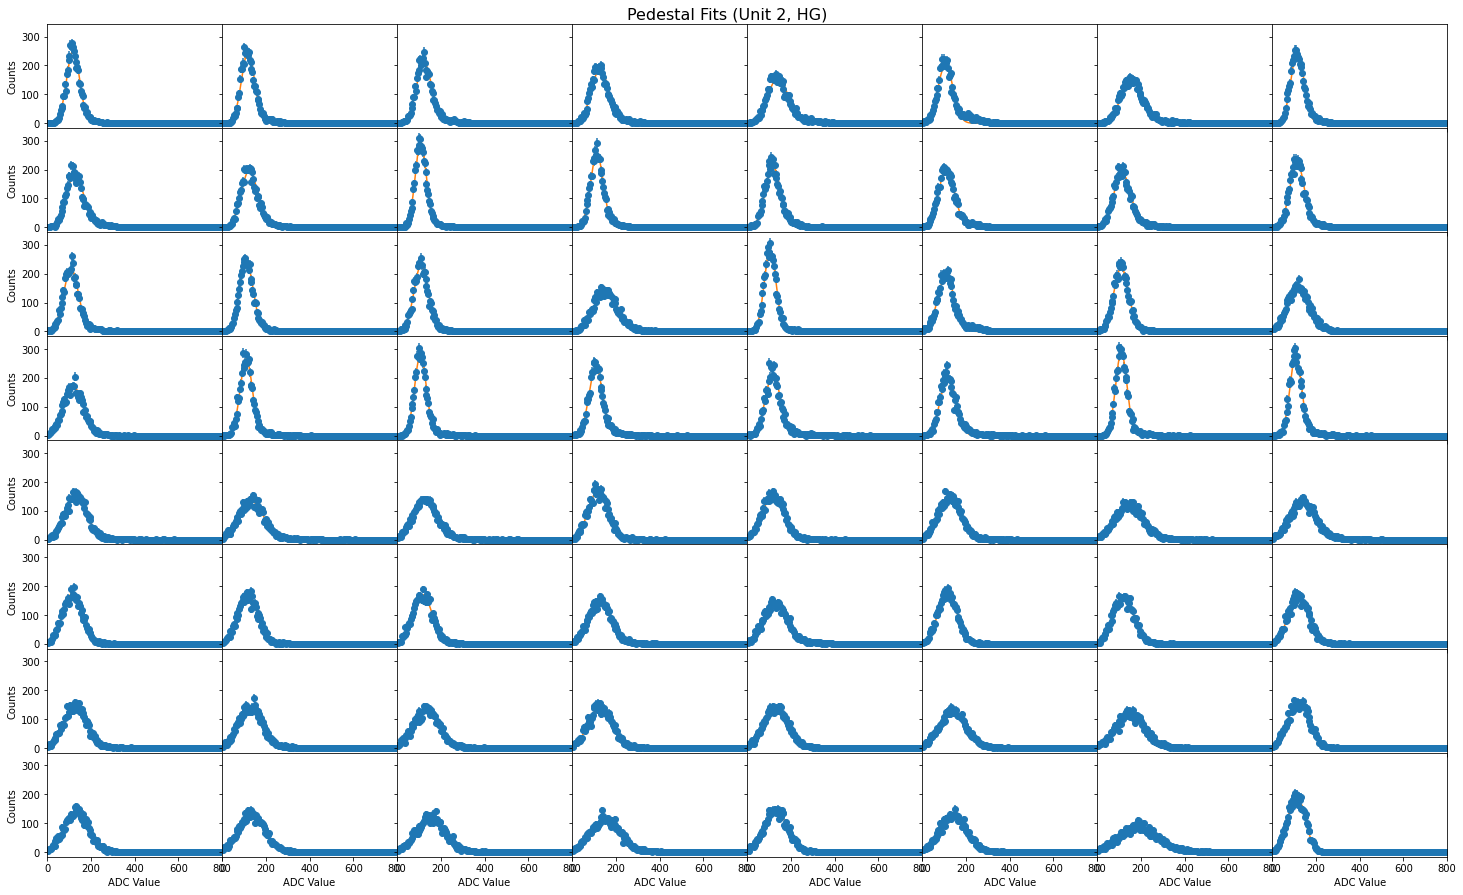

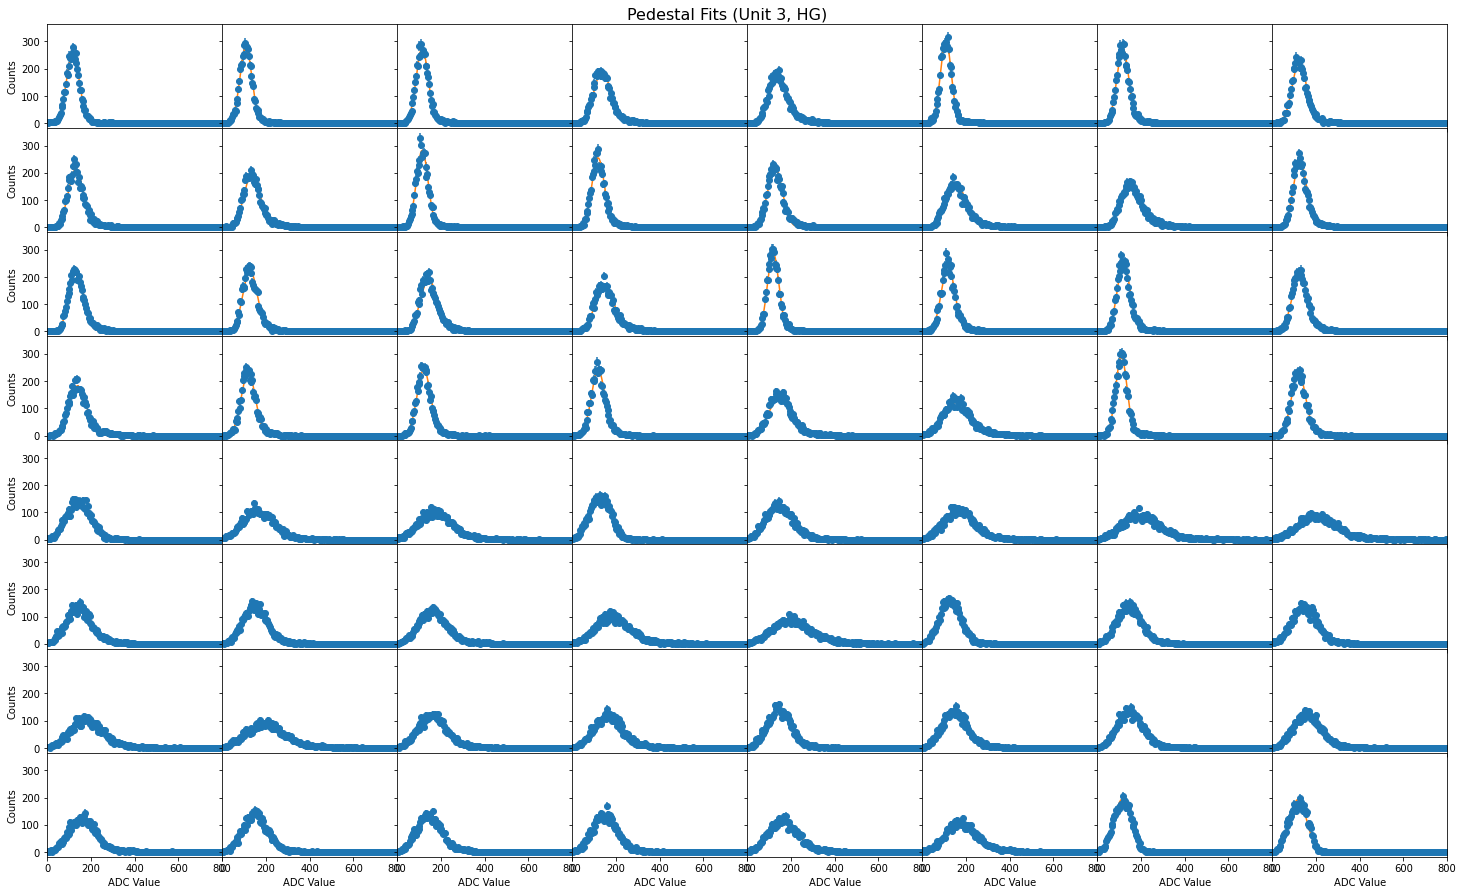

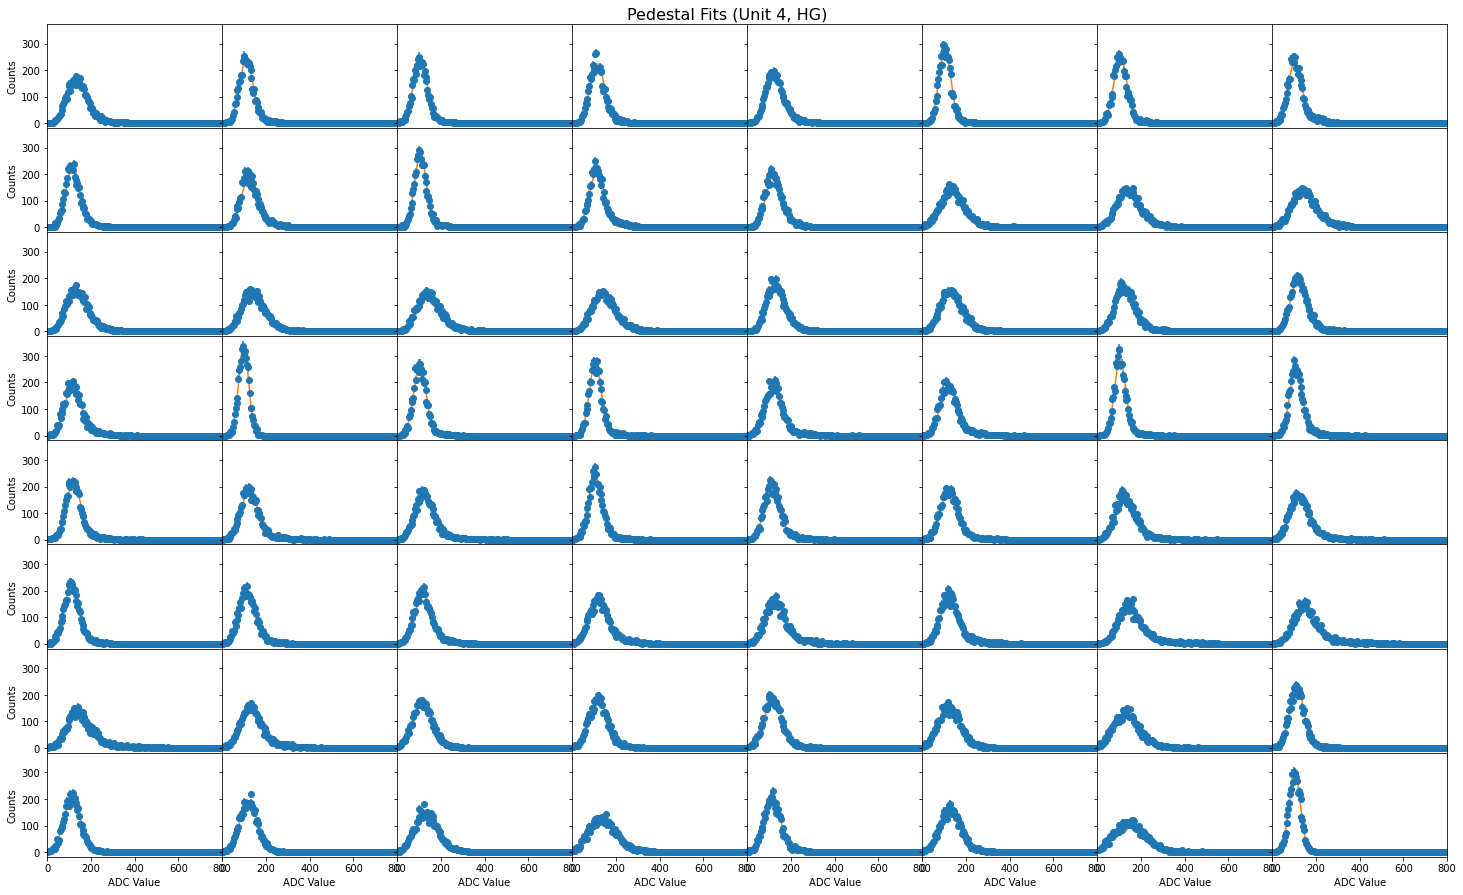

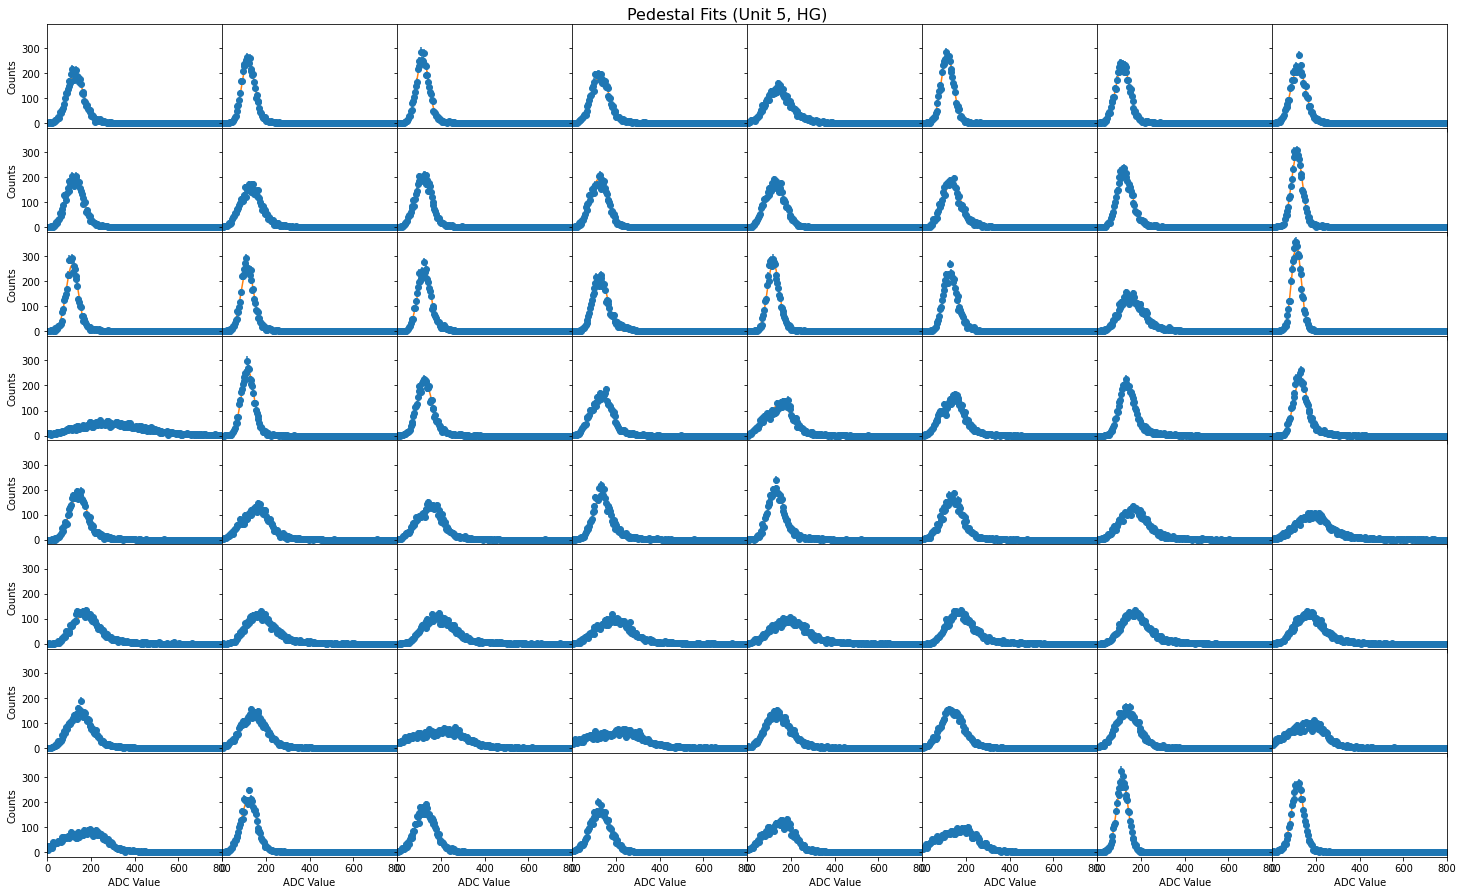

In [5]:
HGPeds, HGPedStd, HGPedsErr, HGPedStdErr = [], [], [], []
for i in range(6):
    analyze_pedestal_unit(din, caen_unit=i, Peds=HGPeds, PedStds=HGPedStd, PedErrs=HGPedsErr, PedStdErrs=HGPedStdErr, gain_type="HG")

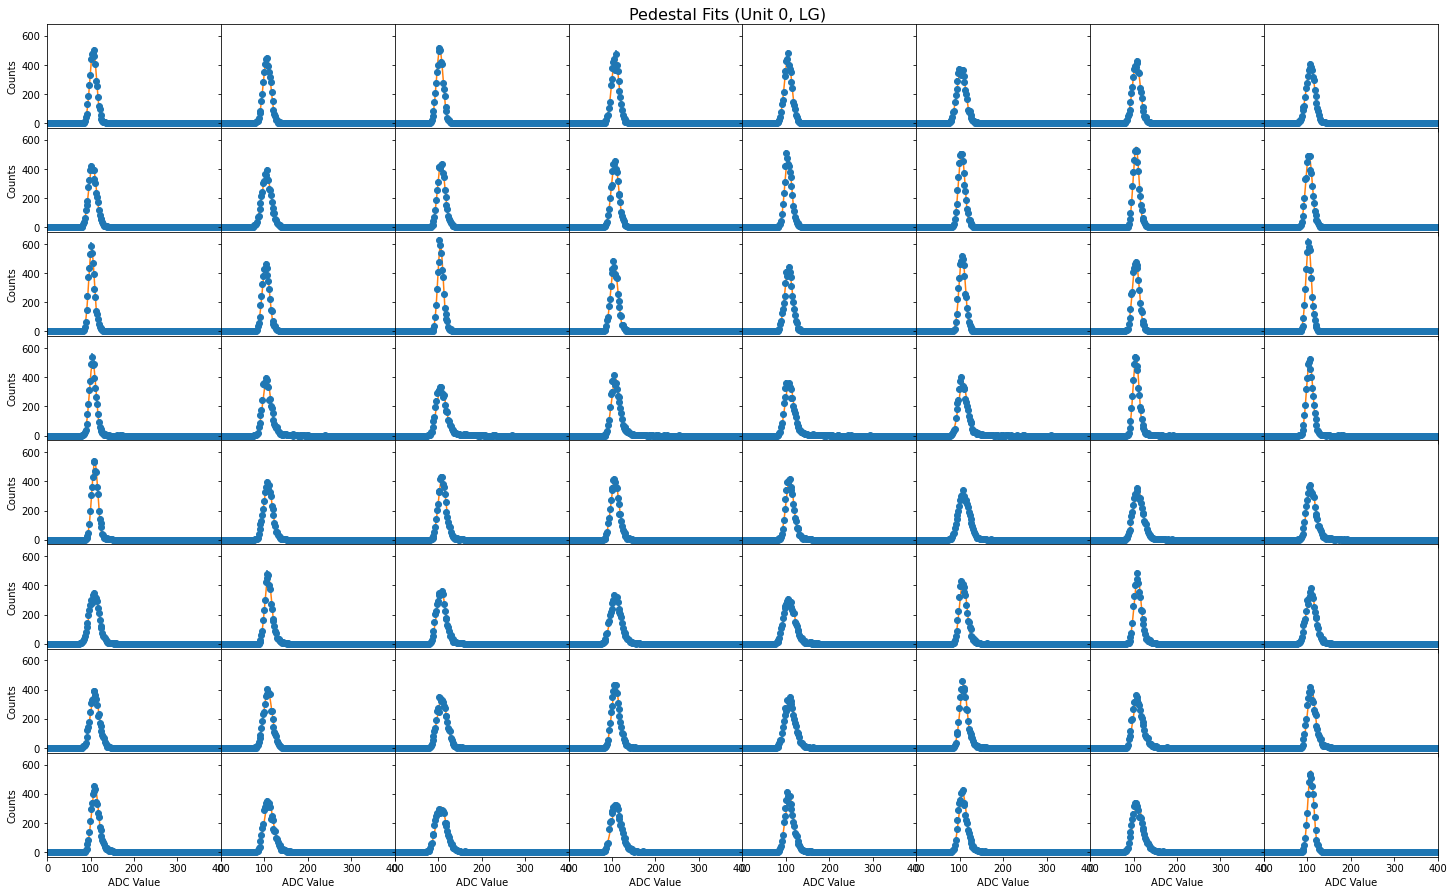

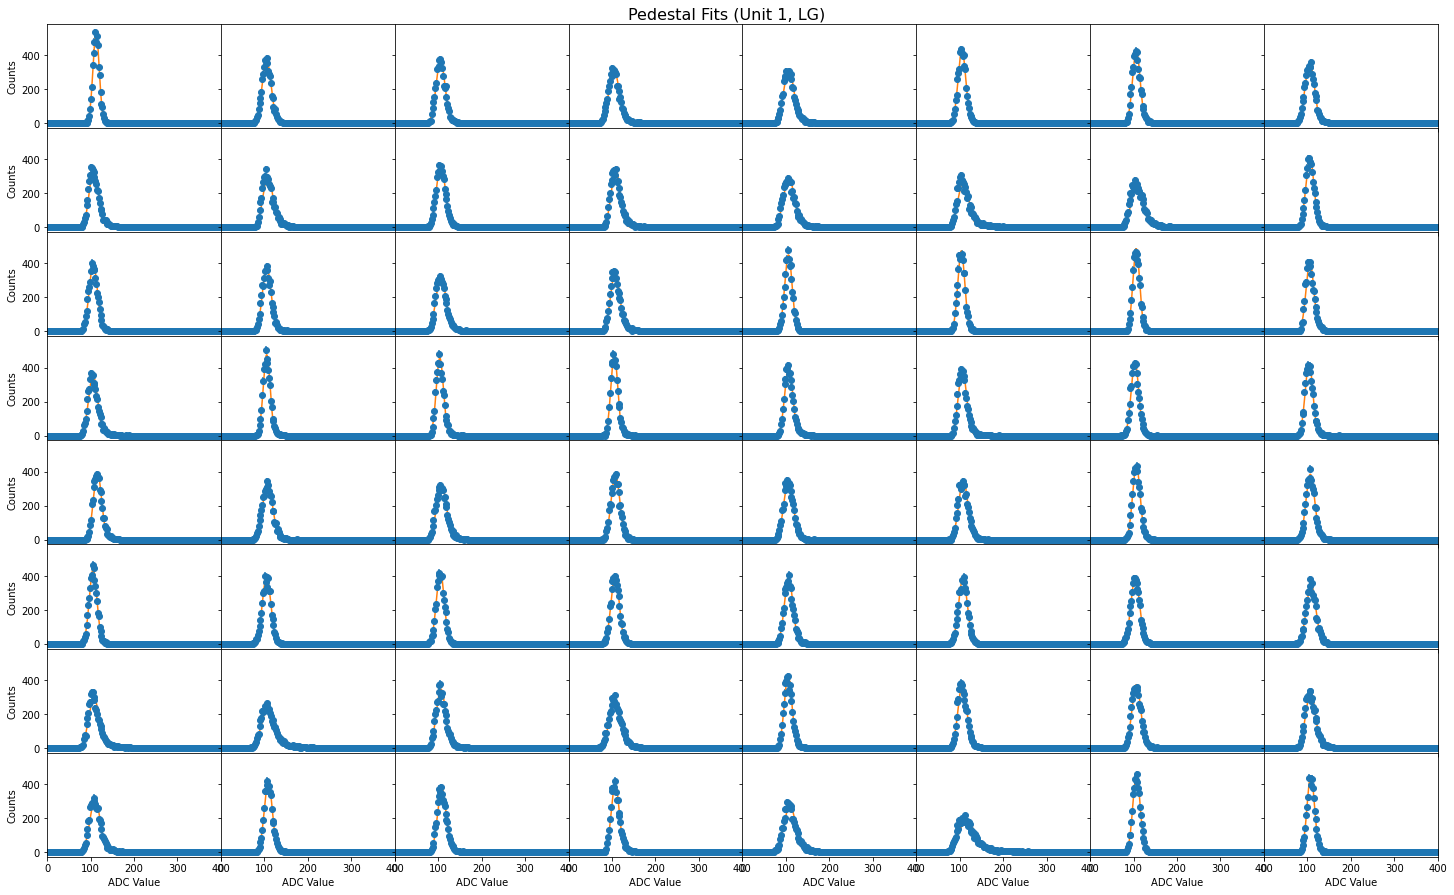

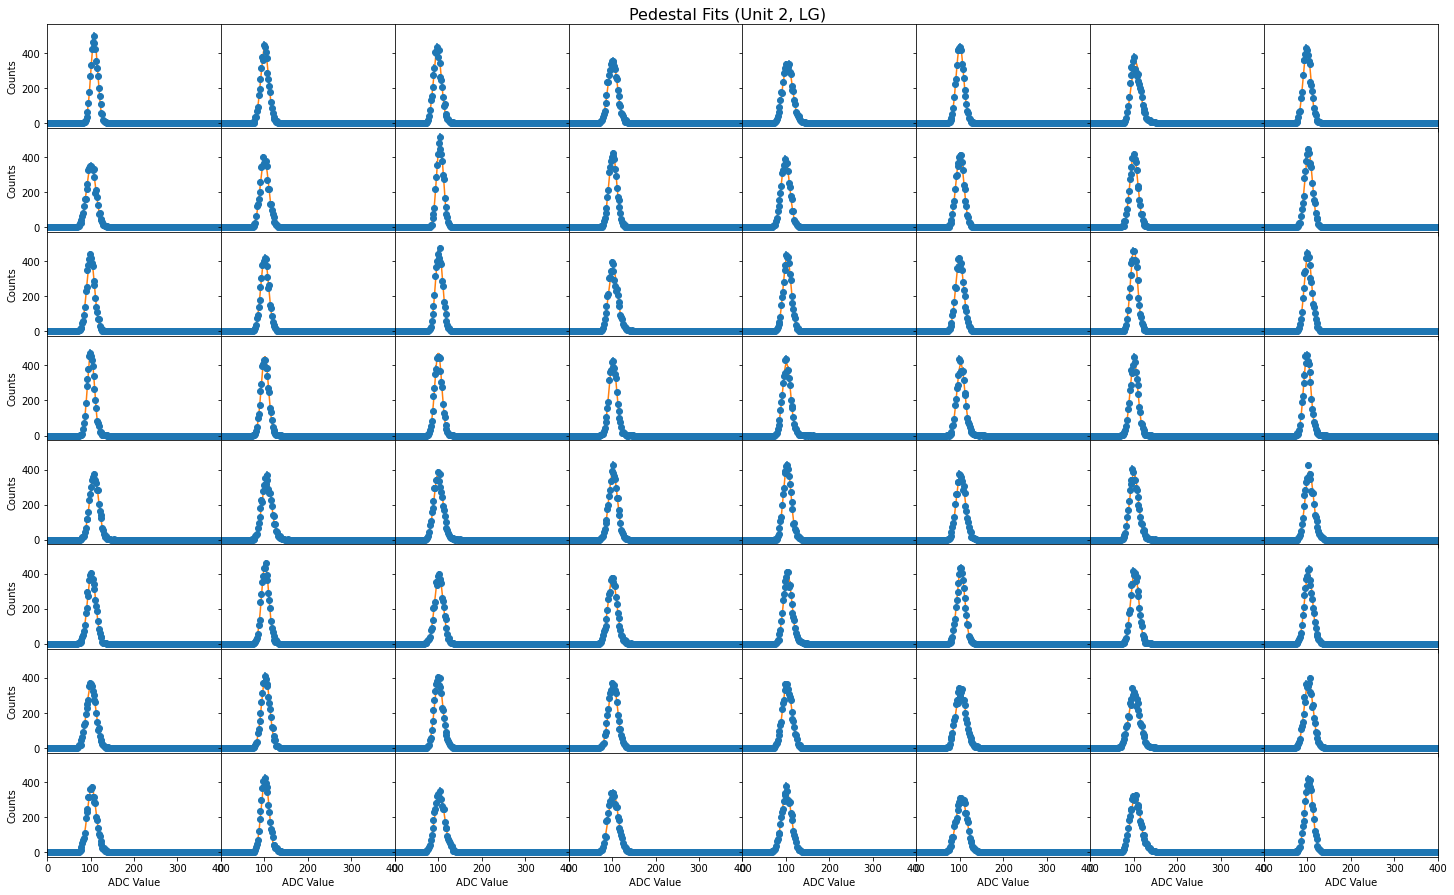

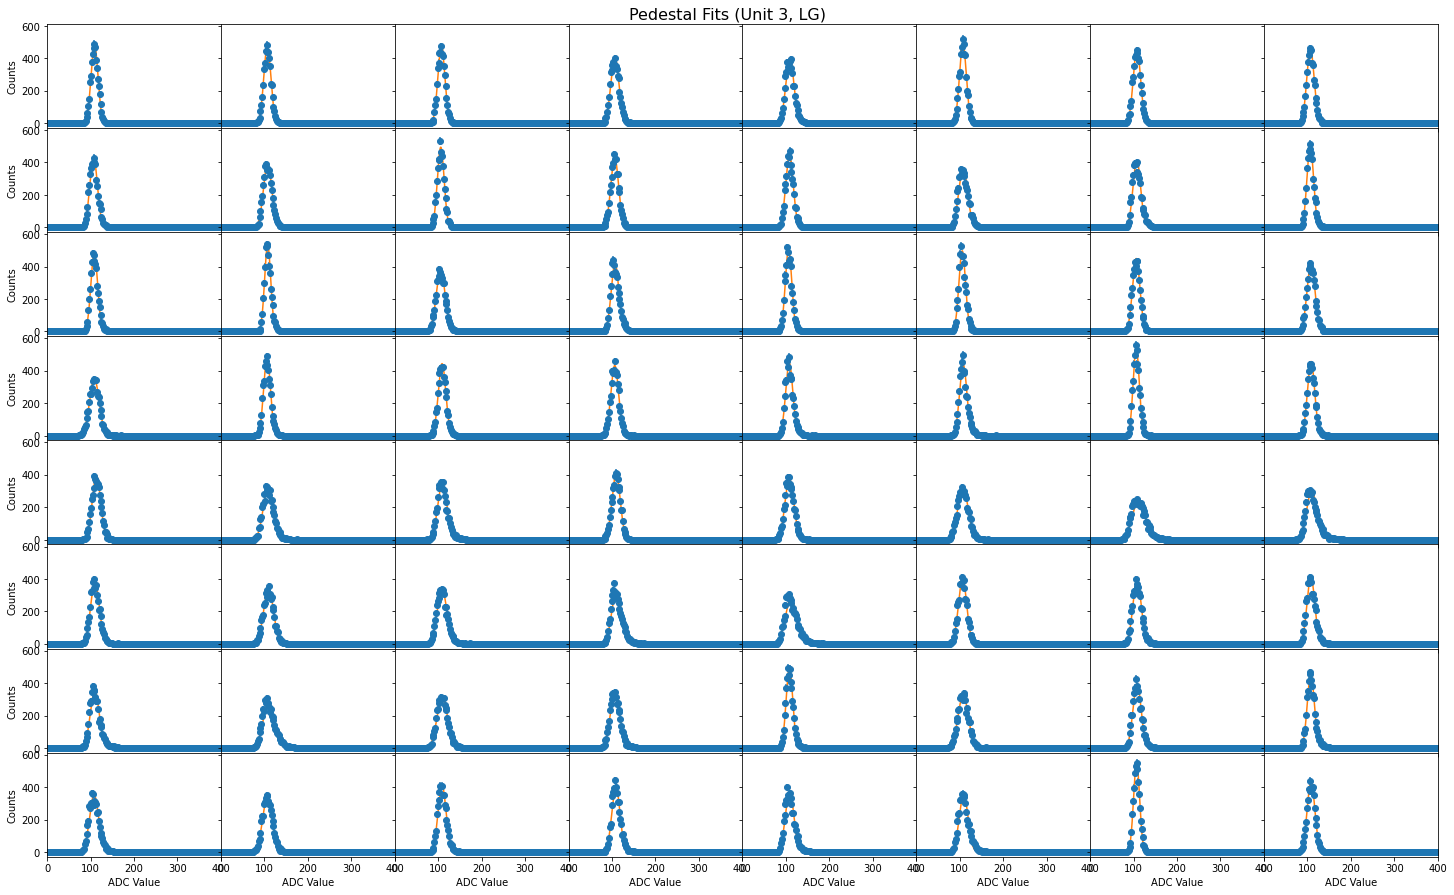

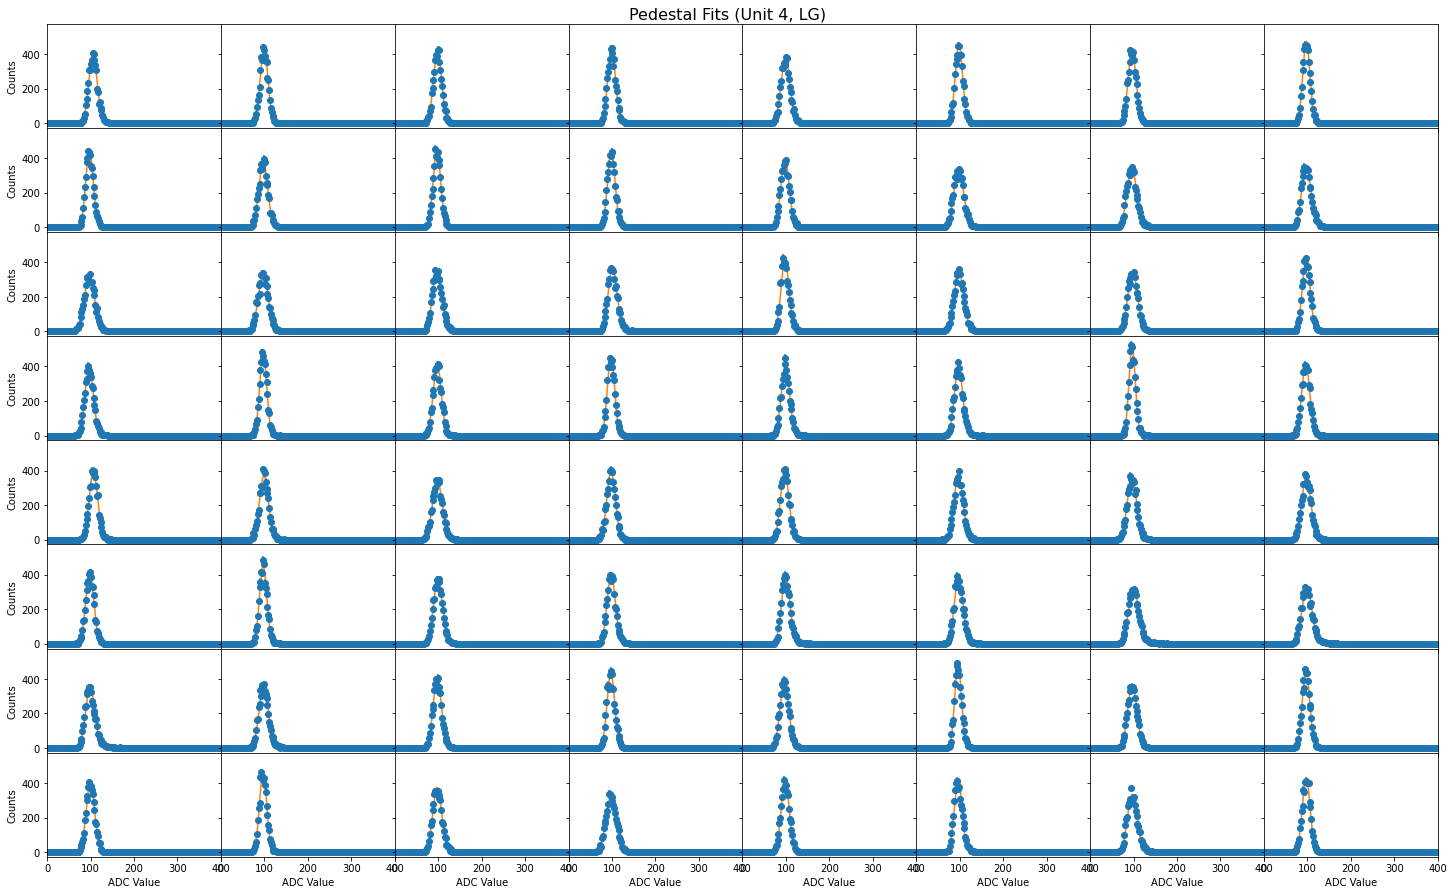

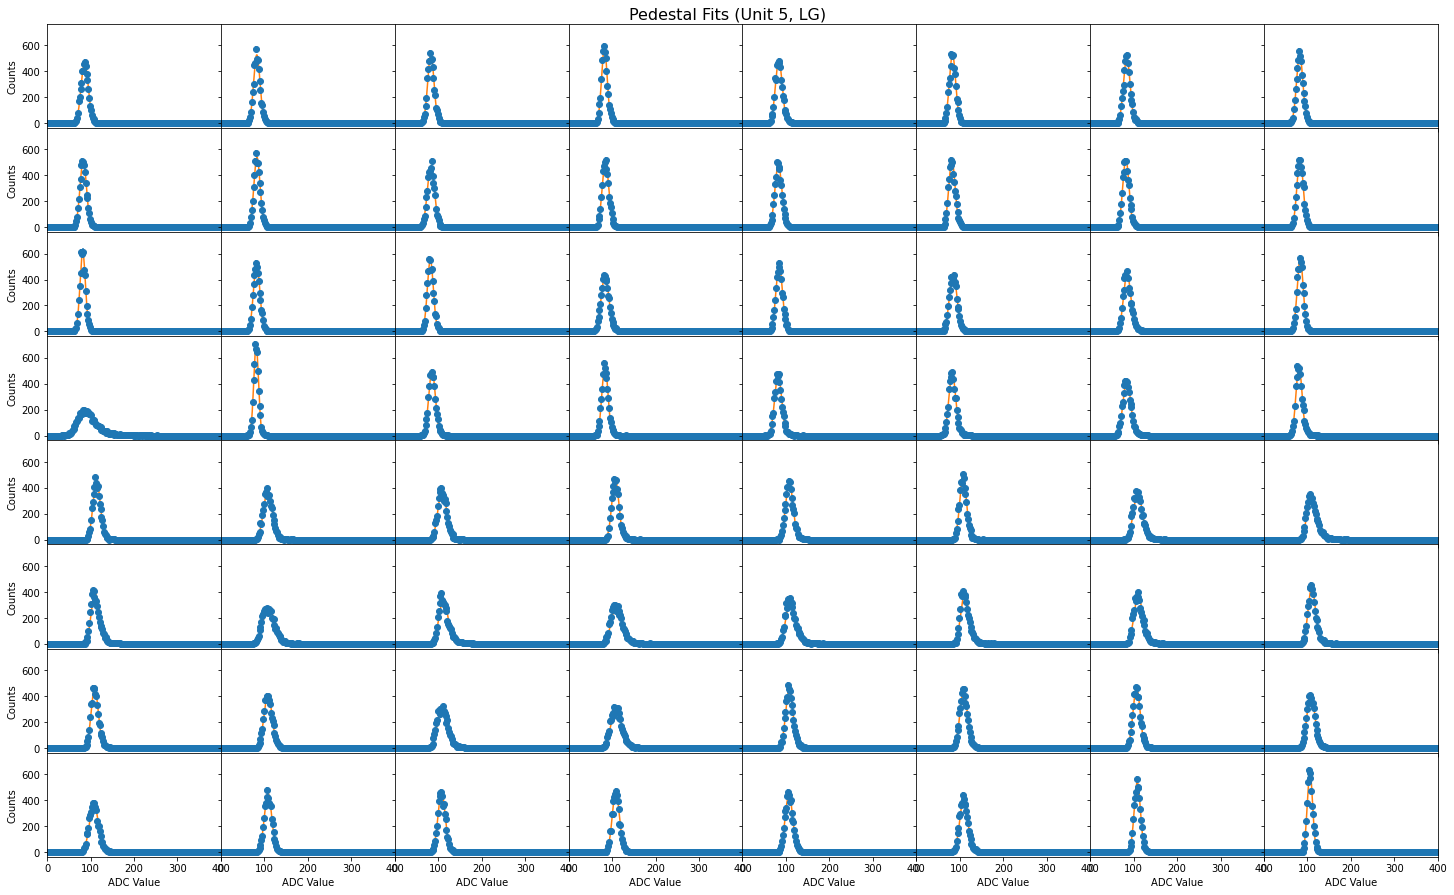

In [6]:
LGPeds, LGPedStd, LGPedsErr, LGPedStdErr = [], [], [], []
for i in range(6):
    analyze_pedestal_unit(din, caen_unit=i, Peds=LGPeds, PedStds=LGPedStd, PedErrs=LGPedsErr, PedStdErrs=LGPedStdErr, gain_type="LG")


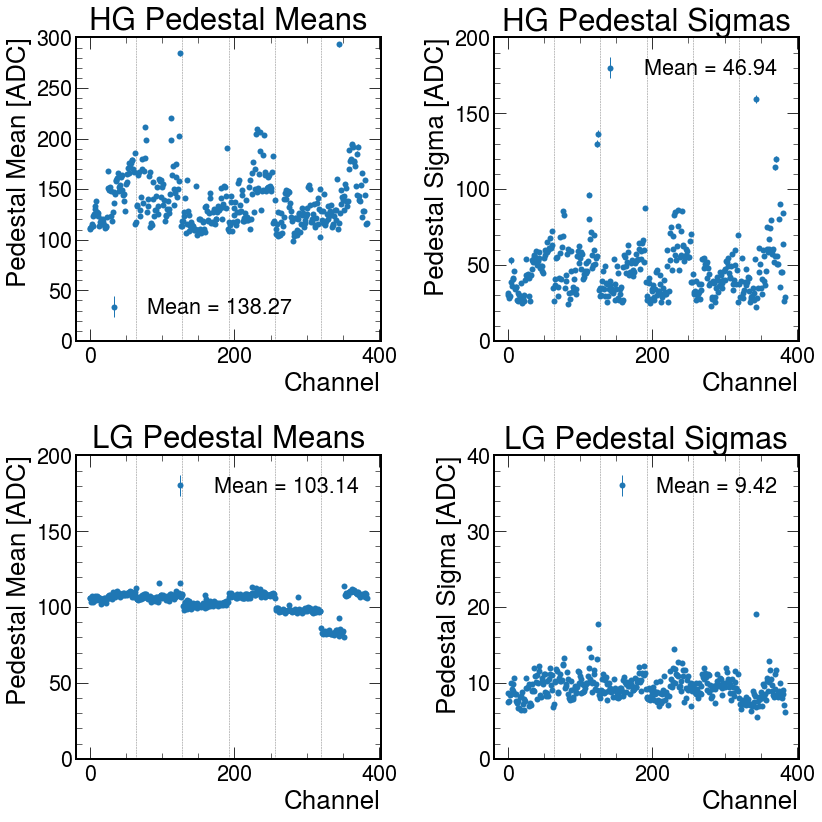

In [7]:
configure_plotting()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create 2x2 grid of subplots
# Calculate max x-value based on the longest array
max_len = max(len(HGPeds), len(HGPedStd), len(LGPeds), len(LGPedStd))

# Add vertical lines at multiples of 64
for ax in axs.flat:
    for x in range(64, max_len, 64):
        ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
mean_val = np.mean(HGPeds)
axs[0, 0].errorbar(x=range(len(HGPeds)), y=HGPeds, yerr=HGPedsErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[0, 0].set_ylim(0, 300)
axs[0, 0].set_title("HG Pedestal Means")
axs[0, 0].set_xlabel("Channel")
axs[0, 0].set_ylabel("Pedestal Mean [ADC]")
axs[0, 0].legend()

# Top right: HG Pedestal Sigmas
mean_val = np.mean(HGPedStd)
axs[0, 1].errorbar(x=range(len(HGPedStd)), y=HGPedStd, yerr=HGPedStdErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[0, 1].set_ylim(0, 200)
axs[0, 1].set_title("HG Pedestal Sigmas")
axs[0, 1].set_xlabel("Channel")
axs[0, 1].set_ylabel("Pedestal Sigma [ADC]")
axs[0, 1].legend()

# Bottom left: LG Pedestal Means
mean_val = np.mean(LGPeds)
axs[1, 0].errorbar(x=range(len(LGPeds)), y=LGPeds, yerr=LGPedsErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[1, 0].set_ylim(0, 200)
axs[1, 0].set_title("LG Pedestal Means")
axs[1, 0].set_xlabel("Channel")
axs[1, 0].set_ylabel("Pedestal Mean [ADC]")
axs[1, 0].legend()

# Bottom right: LG Pedestal Sigmas
mean_val = np.mean(LGPedStd)
axs[1, 1].errorbar(x=range(len(LGPedStd)), y=LGPedStd, yerr=LGPedStdErr, fmt='o',
                   capsize=0, elinewidth=1, markeredgewidth=0,
                   label=f"Mean = {mean_val:.2f}")
axs[1, 1].set_ylim(0, 40)
axs[1, 1].set_title("LG Pedestal Sigmas")
axs[1, 1].set_xlabel("Channel")
axs[1, 1].set_ylabel("Pedestal Sigma [ADC]")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

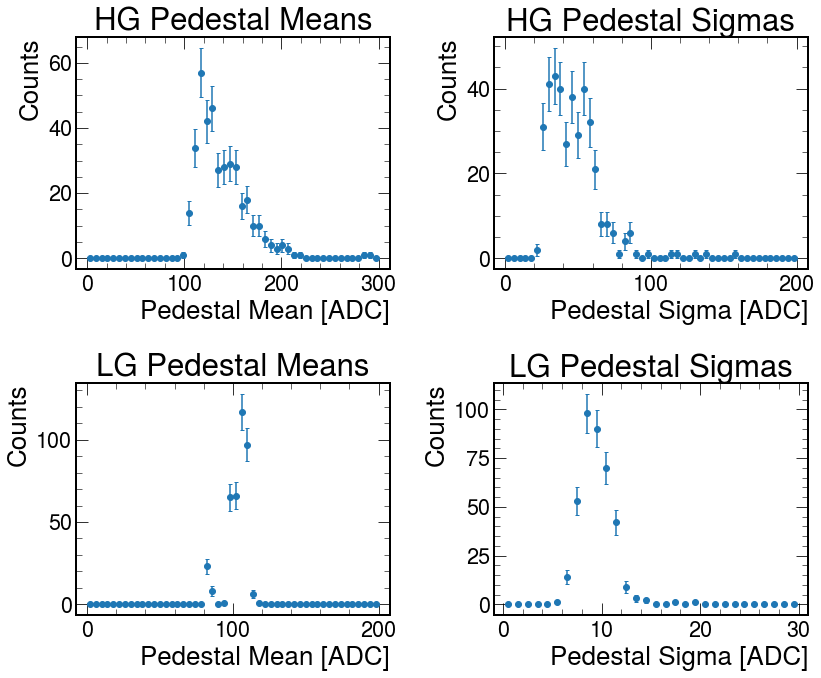

In [8]:
configure_plotting()

# Number of bins for histograms
num_bins = 30

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top left: HG Pedestal Means Histogram
filtered = np.array(HGPeds)[np.array(HGPeds) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 300))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[0, 0].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[0, 0].set_title("HG Pedestal Means")
axs[0, 0].set_xlabel("Pedestal Mean [ADC]")
axs[0, 0].set_ylabel("Counts")

# Top right: HG Pedestal Sigmas Histogram
filtered = np.array(HGPedStd)[np.array(HGPedStd) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 200))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[0, 1].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[0, 1].set_title("HG Pedestal Sigmas")
axs[0, 1].set_xlabel("Pedestal Sigma [ADC]")
axs[0, 1].set_ylabel("Counts")

# Bottom left: LG Pedestal Means Histogram
filtered = np.array(LGPeds)[np.array(LGPeds) > 0]
counts, bin_edges = np.histogram(filtered, bins=50, range=(0, 200))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[1, 0].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[1, 0].set_title("LG Pedestal Means")
axs[1, 0].set_xlabel("Pedestal Mean [ADC]")
axs[1, 0].set_ylabel("Counts")

# Bottom right: LG Pedestal Sigmas Histogram
filtered = np.array(LGPedStd)[np.array(LGPedStd) > 0]
counts, bin_edges = np.histogram(filtered, bins=30, range=(0, 30))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
axs[1, 1].errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
axs[1, 1].set_title("LG Pedestal Sigmas")
axs[1, 1].set_xlabel("Pedestal Sigma [ADC]")
axs[1, 1].set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [9]:
pedestal_data = {
    'HGPedMean': HGPeds,
    'HGPedSigma': HGPedStd,
    'LGPedMean': LGPeds,
    'LGPedSigma': LGPedStd
}

# Save to a .pkl file
with open('../../genIII_data/JLab/Cosmic/CosmicPed.pkl', 'wb') as f:
    pickle.dump(pedestal_data, f)